In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import torch

In [23]:
# === Load your results & cached dataset ===
BASE_DIR = os.getcwd()
results = pd.read_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/test_predictions_resnet.csv")  # contains y_true, y_pred, y_prob
test_cache = np.load(("/home/ubuntu/mucilage_pipeline/mucilage-detection/saved_npy/train_cache.npz"), allow_pickle=True)
X_test, y_test = test_cache["X"], test_cache["y"]   # shapes: (N, H, W, C), (N,)

bands = ['b01','b02', 'b03', 'b04', 'b05', 'b06', 'b07','b08','b8a', 'b11', 'b12']

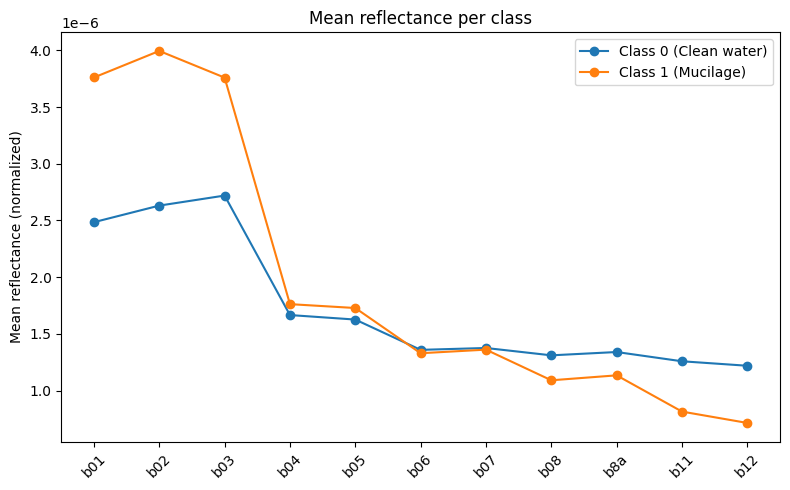

In [24]:
# --- 1. Mean reflectance curves per class ---
mean_class0 = X_test[y_test == 0].mean(axis=(0,1,2))
mean_class1 = X_test[y_test == 1].mean(axis=(0,1,2))

plt.figure(figsize=(8,5))
plt.plot(bands, mean_class0, label="Class 0 (Clean water)", marker="o")
plt.plot(bands, mean_class1, label="Class 1 (Mucilage)", marker="o")
plt.xticks(rotation=45)
plt.ylabel("Mean reflectance (normalized)")
plt.title("Mean reflectance per class")
plt.legend()
plt.tight_layout()
#plt.savefig("/home/ubuntu/mucilage_pipeline/mucilage-detection/plots/resnet/mean_reflectance_classes.png", dpi=300)
plt.show()

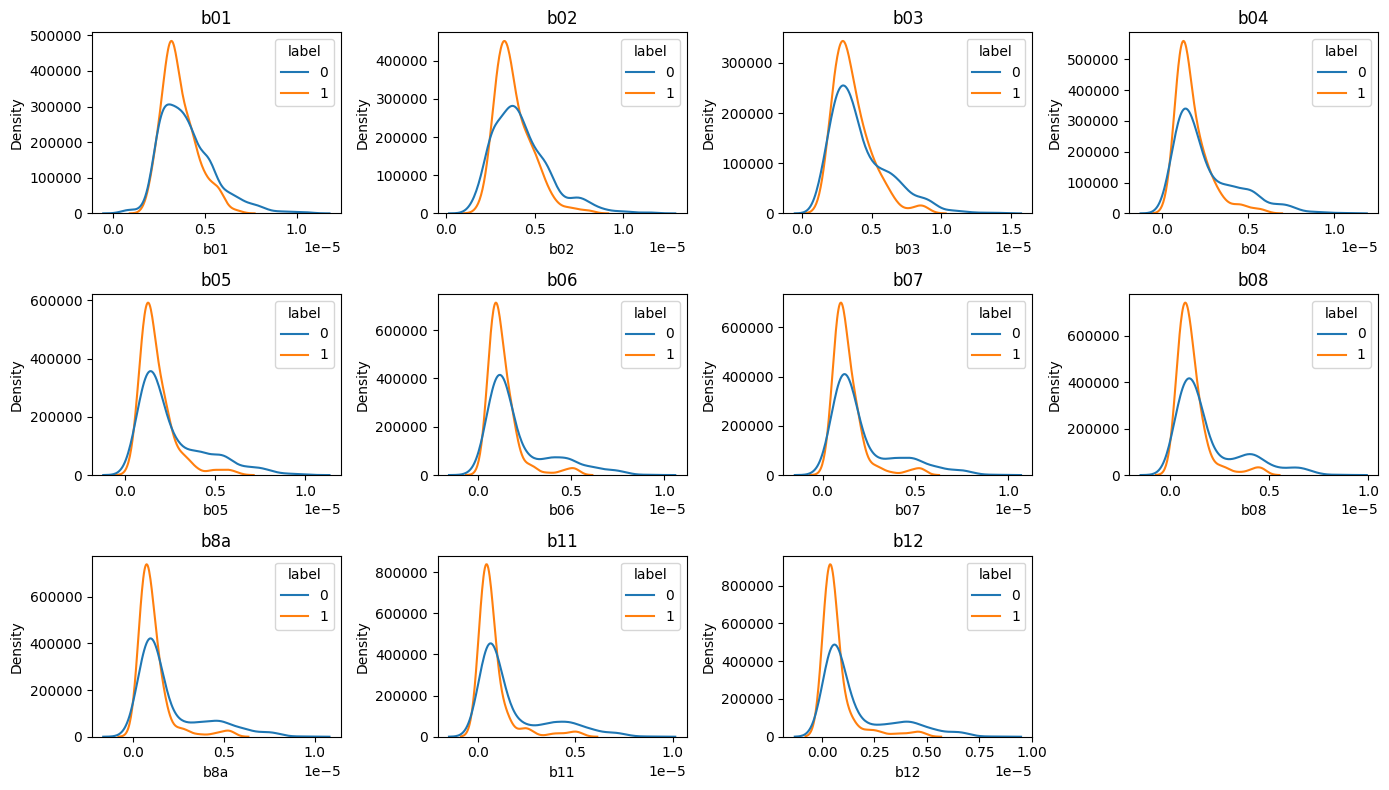

In [25]:
# --- 2. Distribution plots per band ---
df_banddist = pd.DataFrame({
    "label": y_test
})
for i, b in enumerate(bands):
    df_banddist[b] = X_test[:,:,:,i].mean(axis=(1,2))  # average patch reflectance

plt.figure(figsize=(14,8))
for i, b in enumerate(bands):
    plt.subplot(3,4,i+1)
    sns.kdeplot(data=df_banddist, x=b, hue="label", common_norm=False)
    plt.title(b)
plt.tight_layout()
#plt.savefig("/home/ubuntu/mucilage_pipeline/mucilage-detection/plots/resnet/band_distributions.png", dpi=300)
plt.show()


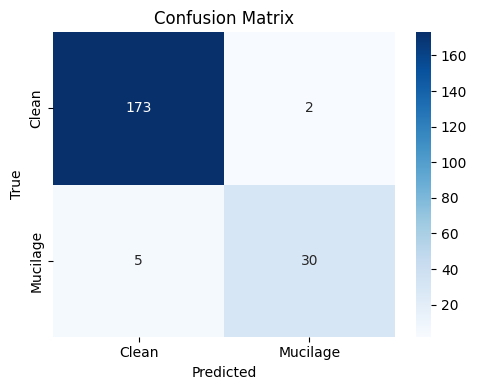


Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       175
           1       0.94      0.86      0.90        35

    accuracy                           0.97       210
   macro avg       0.95      0.92      0.94       210
weighted avg       0.97      0.97      0.97       210



In [26]:
# --- 3. Confusion matrix ---
cm = confusion_matrix(results["y_true"], results["y_pred"])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Clean","Mucilage"], yticklabels=["Clean","Mucilage"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
#plt.savefig("/home/ubuntu/mucilage_pipeline/mucilage-detection/plots/resnet/confusion_matrix.png", dpi=300)
plt.show()

print("\nClassification report:\n", classification_report(results["y_true"], results["y_pred"]))

Feature matrix shape: (955, 11)
Explained variance ratio: [0.91304284 0.06796567]


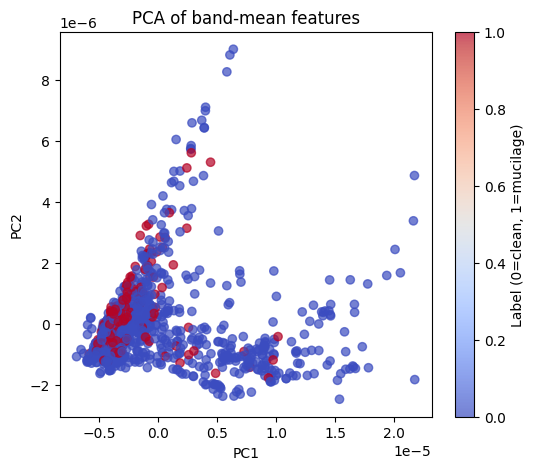

b01: PC1=0.232, PC2=0.296
b02: PC1=0.254, PC2=0.442
b03: PC1=0.331, PC2=0.579
b04: PC1=0.323, PC2=0.147
b05: PC1=0.331, PC2=0.029
b06: PC1=0.308, PC2=-0.170
b07: PC1=0.311, PC2=-0.170
b08: PC1=0.294, PC2=-0.179
b8a: PC1=0.319, PC2=-0.244
b11: PC1=0.310, PC2=-0.328
b12: PC1=0.288, PC2=-0.322


In [27]:
X_band_means = X_test.mean(axis=(1,2))   # (N, C)
print("Feature matrix shape:", X_band_means.shape)  # (N_samples, 11)

pca = PCA(n_components=2)
proj = pca.fit_transform(X_band_means)

print("Explained variance ratio:", pca.explained_variance_ratio_)

plt.figure(figsize=(6,5))
plt.scatter(proj[:,0], proj[:,1], c=y_test, cmap="coolwarm", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of band-mean features")
plt.colorbar(label="Label (0=clean, 1=mucilage)")
plt.show()

# Band loadings (how much each band contributes to PC1/PC2)
for i, band in enumerate(bands):
    print(f"{band}: PC1={pca.components_[0,i]:.3f}, PC2={pca.components_[1,i]:.3f}")

In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_band_means)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_scaled, y_test)

coeffs = logreg.coef_[0]

# Positive coeff = pushes towards class 1 (mucilage), negative = towards class 0 (clean)
print("\nLogistic regression band importances:")
for band, coef in sorted(zip(bands, coeffs), key=lambda x: -abs(x[1])):
    print(f"{band}: {coef:.3f}")


Logistic regression band importances:
b04: -1.610
b07: 1.382
b12: -1.288
b06: 1.003
b03: 0.917
b11: -0.703
b05: -0.671
b8a: 0.546
b08: -0.512
b02: 0.274
b01: -0.190


/tmp/ipykernel_445160/1335534373.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="band", data=importance_df, palette="viridis")


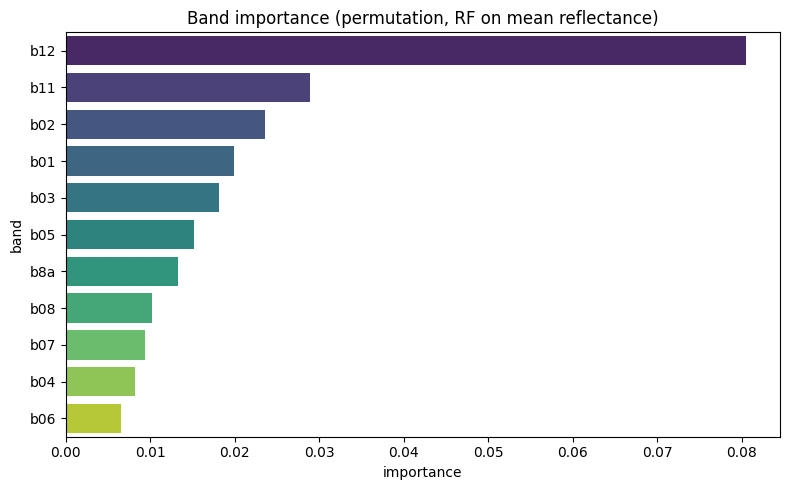

Top contributing bands:
    band  importance
10  b12    0.080524
9   b11    0.028901
1   b02    0.023560
0   b01    0.019895
2   b03    0.018115
4   b05    0.015183
8   b8a    0.013298
7   b08    0.010157
6   b07    0.009319
3   b04    0.008168
5   b06    0.006492


In [29]:
from sklearn.ensemble import RandomForestClassifier

# Simplify: Train a quick RF classifier on mean reflectance values
X_features = df_banddist[bands].values
y_features = df_banddist["label"].values

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_features, y_features)

perm = permutation_importance(rf, X_features, y_features, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    "band": bands,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="importance", y="band", data=importance_df, palette="viridis")
plt.title("Band importance (permutation, RF on mean reflectance)")
plt.tight_layout()
#plt.savefig("/home/ubuntu/mucilage_pipeline/mucilage-detection/plots/resnet/band_importance.png", dpi=300)
plt.show()

print("Top contributing bands:\n", importance_df)